# Le Debruiteur
* Jonas Freiburghaus
* Romain Capocasale
* He-Arc, INF3dlm-a
* Image Processing course
* 2019-2020

## Statistics

In [9]:
import os

from debruiteur.generator.datagenerator import DataGenerator
from debruiteur.preprocessing.preprocessor import make_original_dataframe, make_resized_dataframe, make_noised_dataframe
from debruiteur.noise.noise import GaussianNoise, PoissonNoise, UniformNoise, SaltPepperNoise, SquareMaskNoise, SpeckleNoise
from debruiteur.utils.utils import load_model, split_train_val_df
from debruiteur.noise.filters import gaussian_filter, wiener_filter, laplacian_filter, gaussian_weighted_substract_filter, mean_filter, median_filter, conservative_filter, fft_filter
from debruiteur.statistics.statistics import compute_noise_reduction_method_statistics, compute_noise_type_statistics
from debruiteur.metrics.metrics import metrics_example

In [2]:
noise_class_list = [
    GaussianNoise(mean=0, std=20),
    PoissonNoise(),
    UniformNoise(amplitude=100),
    SaltPepperNoise(),
    SquareMaskNoise(mask_shape=(10, 10), freq=0.1),
    SpeckleNoise(),
]

### Load data

In [3]:
working_dir = os.path.abspath(os.getcwd())

df_original = make_original_dataframe(os.path.join(working_dir, "images"))
df_resized = make_resized_dataframe(df_original, img_shape=(100, 100), resized_path=os.path.join(working_dir, "resized_images"))
df_noised = make_noised_dataframe(df_resized, noise_class_list, os.path.join(working_dir, "noised_images"))

### Metrics

Mean squared error (MSE) :
$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

Normalized root mean squared error (NRMSE) :
$$\text{NRMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n}\left(\log{\frac{\hat{y} + 1}{y + 1}}\right)^2}$$

Peak signal to noise ration (PSNR) :
$$\text{PSNR} = 10 \log_{10} \left( \frac{{MAX_{I}^2}}{MSE} \right)$$

Structural similarity (SSIM) :
$$\text{SSIM(x, y)} = \frac{(2\mu_x \mu_y + c_1)(2\sigma_{xy} + c_2)}{(\mu_x^2 + \mu_y^2 + c_1)(\sigma_x^2 + \sigma_y^2 + c_2)}$$

### Show metrics example

C:\Users\jonas.freiburg\Documents\Niveau3\imagerie\traitement_image\projet\ledebruiteur\debruiteur\metrics\metrics.py:65: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ssim = metrics.structural_similarity(orignal_img, noised_img)


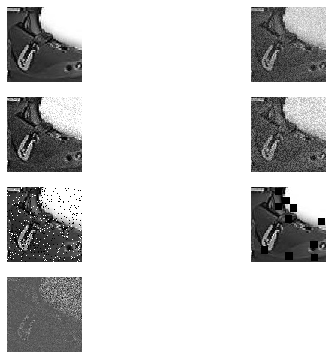

,Noise,MSE,NRMSE,PSNR,SSIM
0,GaussianNoise,395.851048,0.146520,22.155486,0.432477
1,PoissonNoise,234.619300,0.112801,24.427166,0.511481
2,UniformNoise,3302.251646,0.423191,12.942702,0.302983
3,SaltPepperNoise,2362.616700,0.357954,14.396871,0.270759
4,SquareMaskNoise,1879.027400,0.319225,15.391472,0.804107
5,SpeckleNoise,17968.067438,0.987147,5.585790,0.129489


In [4]:
metrics_example(df_noised, noise_class_list)

You can see the score for each type of noise for each metric. We can notice that the type of noise that deteriorates the image the most is SpeckleNoise. We can also see that the Gaussian, Poisson noise is one of the filters that deteriorates the image the least. 

### Create data generator

In [5]:
stats_gen = DataGenerator(df_noised[0:20], batch_size=20)

### Load models

In [6]:
conv_ae_model = load_model(os.path.join(working_dir, "saved_models"), "conv_autoencoder.h5")
dense_ae_model = load_model(os.path.join(working_dir, "saved_models"), "dense_autoencoder.h5")
gan_model = load_model(os.path.join(working_dir, "saved_models"), "gan_generator.h5")

C:\Users\jonas.freiburg\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python\keras\layers\core.py:986: UserWarning: debruiteur.models.gan is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


### Noise reduction methods

In [10]:
"""noise_reduction_methods = [('Wiener Filter', lambda img: wiener_filter(img * 255)),
                           ('Laplacian Filter', lambda img: laplacian_filter(img * 255)),
                           ('Gaussian Weighted Filter', lambda img: gaussian_weighted_substract_filter(img * 255)),
                           ('Mean Filter', lambda img: mean_filter(img * 255)),
                           ('Median Filter', lambda img: median_filter(img * 255)),
                           ('Conservative Filter', lambda img: conservative_filter(img * 255)),
                           ('Low pass FFT Filter', lambda img: fft_filter(img * 255)),
                           ('Convolutional Autoencoder', lambda x : conv_ae_model.predict(x.reshape(1, 100, 100, 1)) * 255),
                           ('Dense Autoencoder', lambda x : dense_ae_model.predict(x.reshape(1, 10000)) * 255),
                           ('Generative Adversarial Network', lambda x : gan_model.predict(x.reshape(1, 100, 100, 1)) * 255)]"""

noise_reduction_methods = [('Gaussian Filter', lambda img: gaussian_filter(img * 255)),
                           ('Mean Filter', lambda img: mean_filter(img * 255)),
                           ('Median Filter', lambda img: median_filter(img * 255)),
                           ('Conservative Filter', lambda img: conservative_filter(img * 255)),
                           ('Low pass FFT Filter', lambda img: fft_filter(img * 255)),
                           ('Convolutional Autoencoder', lambda x : conv_ae_model.predict(x.reshape(1, 100, 100, 1)) * 255),
                           ('Dense Autoencoder', lambda x : dense_ae_model.predict(x.reshape(1, 10000)) * 255),
                           ('Generative Adversarial Network', lambda x : gan_model.predict(x.reshape(1, 100, 100, 1)) * 255)]

### Noise reduction methods metrics averaged on all kind of noises

In [11]:
compute_noise_reduction_method_statistics(stats_gen, noise_reduction_methods)

Compute finish for Gaussian Filter
Compute finish for Mean Filter
Compute finish for Median Filter
Compute finish for Conservative Filter
Compute finish for Low pass FFT Filter
Compute finish for Convolutional Autoencoder
Compute finish for Dense Autoencoder
Compute finish for Generative Adversarial Network


,MSE,NRMSE,PSNR,SSIM
Gaussian Filter,1116.287730,0.249265,18.427501,0.522268
Mean Filter,1314.336957,0.274196,17.461562,0.385839
Median Filter,1206.791775,0.258408,18.251413,0.451304
Conservative Filter,1490.275035,0.278684,17.486341,0.631594
Low pass FFT Filter,1149.696637,0.251516,18.262157,0.558033
Convolutional Autoencoder,3954.830617,0.477050,12.476476,0.143724
Dense Autoencoder,5611.229747,0.575467,10.724827,0.008333
Generative Adversarial Network,2764.116981,0.394394,14.155652,0.471215


### Noise reductions methods for each noise type
#### Structural similarity (SSIM)

A high SSIM is desired

In [12]:
df_stat_ssim = compute_noise_type_statistics(stats_gen, noise_reduction_methods, noise_class_list, "SSIM")
df_stat_ssim

Compute finish for Gaussian Filter
Compute finish for Mean Filter
Compute finish for Median Filter
Compute finish for Conservative Filter
Compute finish for Low pass FFT Filter
Compute finish for Convolutional Autoencoder
Compute finish for Dense Autoencoder
Compute finish for Generative Adversarial Network


In [30]:
df_stat_ssim.mean(axis=1).sort_values()

Dense Autoencoder                 0.007565
Convolutional Autoencoder         0.135444
Mean Filter                       0.320488
Median Filter                     0.368133
Generative Adversarial Network    0.423867
Gaussian Filter                   0.446897
Low pass FFT Filter               0.508938
Conservative Filter               0.565793
dtype: float64

#### Peak signal-to-noise ratio (PSNR)

A High PSNR is desired but not in all cases. It is often used as a reconstruction loss when compressing images.

In [13]:
df_stat_psnr = compute_noise_type_statistics(stats_gen, noise_reduction_methods, noise_class_list, "PSNR")
df_stat_psnr

Compute finish for Gaussian Filter
Compute finish for Mean Filter
Compute finish for Median Filter
Compute finish for Conservative Filter
Compute finish for Low pass FFT Filter
Compute finish for Convolutional Autoencoder
Compute finish for Dense Autoencoder
Compute finish for Generative Adversarial Network


In [32]:
df_stat_psnr.mean(axis=1).sort_values()

Dense Autoencoder                 10.687184
Convolutional Autoencoder         12.339087
Generative Adversarial Network    13.361785
Mean Filter                       16.475217
Median Filter                     16.949965
Gaussian Filter                   17.284849
Conservative Filter               17.624347
Low pass FFT Filter               17.705882
dtype: float64

#### Mean squared error (MSE)

A low MSE is desired.

In [14]:
df_stat_mse = compute_noise_type_statistics(stats_gen, noise_reduction_methods, noise_class_list, "MSE")
df_stat_mse

Compute finish for Gaussian Filter
Compute finish for Mean Filter
Compute finish for Median Filter
Compute finish for Conservative Filter
Compute finish for Low pass FFT Filter
Compute finish for Convolutional Autoencoder
Compute finish for Dense Autoencoder
Compute finish for Generative Adversarial Network


In [28]:
df_stat_mse.mean(axis=1).sort_values()

Low pass FFT Filter               1504.751424
Gaussian Filter                   1585.886885
Conservative Filter               1615.626241
Median Filter                     1740.016526
Mean Filter                       1818.595344
Generative Adversarial Network    3344.393663
Convolutional Autoencoder         4074.287172
Dense Autoencoder                 5661.088004
dtype: float64

#### Root mean squared error (RMSE)

A low RMSE is desired.

In [15]:
df_stat_rmse = compute_noise_type_statistics(stats_gen, noise_reduction_methods, noise_class_list, "NRMSE")
df_stat_rmse

Compute finish for Gaussian Filter
Compute finish for Mean Filter
Compute finish for Median Filter
Compute finish for Conservative Filter
Compute finish for Low pass FFT Filter
Compute finish for Convolutional Autoencoder
Compute finish for Dense Autoencoder
Compute finish for Generative Adversarial Network


In [ ]:
df_stat_rmse.mean(axis=1).sort_values()

# Conclusion

As we can observe the conservative filter has the best score on all most all type of noises.  
It may be because the changes in the images are very small so it the denoised image is similar to the original image.  
This is particularly true when the images are not very noised and the performance would be different if the images had more noise.  

The generative adversial neural network reduces the noise quite well, but as the image is generated, the colors are sometimes different which is not the case of other filters.  
When we sum all these small differences pixelwise it is expected to have a high error.  
Even though the results are visually good.  

For each filter the metrics where computed on all kind of noises.  
Usually we should use a specific filter on a particular noise as they perform better on the approriate noise.  

Comparing the neural networks, the generative adversial neural network has the best performances.  
If we had a GPU with more RAM, we could increase the depth of the GAN by putting more convolutional blocks.  
This is also the reason why we reduced the image's size to 100x100 and used grayscale.  
An other improvement would be to implement the style loss in order to keep better texture details and so improve the performance.  

Another point to note is that the structural similarity has been criticized for not being more corelated to the human's perception as the mean squarred error.  
Comparing the images visually is sometimes more valuable than comparing metrics.  

This conclusion shouldn't be used to say that classical filters (gaussian etc) perform better than neural networks in all cases.  